# Quora Question Pairs Similarity

# 1. Business Problem

## 1.1 Description

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.


Credits: Kaggle

#### Problem Statement

    ->Identify which questions asked on Quora are duplicates of questions that have already been asked.
    ->This could be useful to instantly provide answers to questions that have already been answered.
    ->We are tasked with predicting whether a pair of questions are duplicates or not.

## 1.2 Sources/Useful Links

Source : https://www.kaggle.com/c/quora-question-pairs 

#### Useful Links
Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments    
Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0       

Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning

Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

## 1.3 Real world/Business Objectives and Constraints

    1.The cost of a mis-classification can be very high.
    2.You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
    3.No strict latency concerns.
    4.Interpretability is partially important.

# 2. Machine Learning Probelm

## 2.1 Data

### 2.1.1 Data Overview

- Data will be in a file Train.csv 
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate 
- Size of Train.csv - 60MB 
- Number of rows in Train.csv = 404,290

### 2.1.2 Example Data point

    "id","qid1","qid2","question1","question2","is_duplicate"
    "0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
    "1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
    "7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
    "11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"

## 2.2 Mapping the real world problem to an ML problem

### 2.2.1 Type of Machine Leaning Problem

It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.

### 2.2.2 Performance Metric

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

#### Metric(s):
log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
                   
Binary Confusion Matrix

## 2.3 Train and Test Construction

We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with.

In [26]:
!pip install distance

# 3. Exploratory Data Analysis

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [28]:
df = pd.read_csv("../input/train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [29]:
df = df.sample(100000)#sampling the data of size 100k

In [30]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
187028,187028,285135,285136,What are some strange laws enforced in various...,What are some bizarre laws in the world?,1
196369,196369,110659,297058,What makes a good software development manager?,How do we find good software developers?,0
330578,330578,38660,457365,What is cached data? Will it cause any problem...,How do you clear the ARP cache?,0
167966,167966,49878,43943,Which software can download a YouTube playlist?,How do I download a whole playlist of 40 video...,1
79989,79989,136084,136085,What is a best gaming laptop below $700?,What's the best gaming laptop under $700?,1


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 187028 to 143101
Data columns (total 6 columns):
id              100000 non-null int64
qid1            100000 non-null int64
qid2            100000 non-null int64
question1       99999 non-null object
question2       99999 non-null object
is_duplicate    100000 non-null int64
dtypes: int64(4), object(2)
memory usage: 5.3+ MB


We are given a minimal number of data fields here, consisting of:

- id: Looks like a simple rowID
- qid{1, 2}: The unique ID of each question in the pair
- question{1, 2}: The actual textual contents of the questions.
- is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.

### 3.2.1 Distribution of data points among output classes
- Number of duplicate(smilar) and non-duplicate(non similar) questions

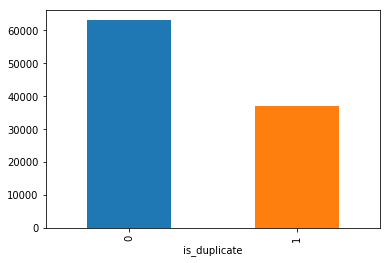

In [32]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [33]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   100000


In [34]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.05%

~> Question pairs are Similar (is_duplicate = 1):
   36.95%


### 3.2.2 Number of unique questions

In [35]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 166320

Number of unique questions that appear more than one time: 19248 (11.572871572871572%)

Max number of times a single question is repeated: 34



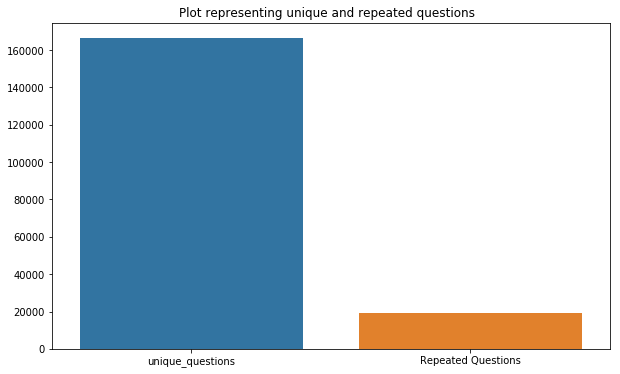

In [36]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

### 3.2.3 Checking for Duplicates

In [37]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


### 3.2.4 Number of occurrences of each question

Maximum number of times a single question is repeated: 34



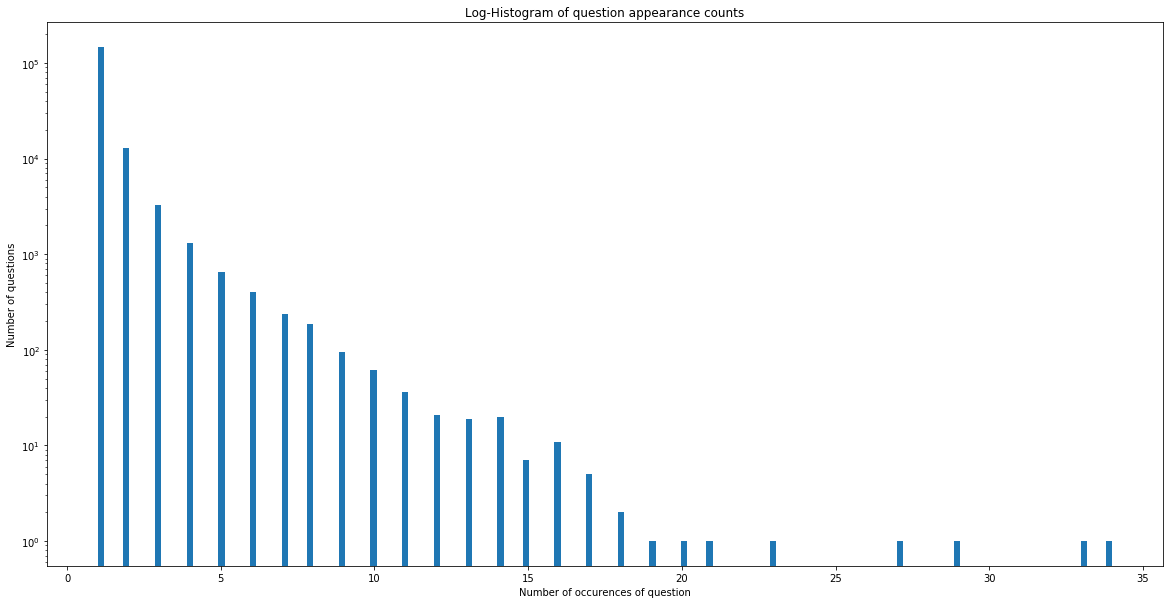

In [38]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

### 3.2.5 Checking for NULL values

In [39]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id      ...       is_duplicate
105780  105780      ...                  0
363362  363362      ...                  0

[2 rows x 6 columns]


In [40]:
# the original data has null values. So wile saompling the data their may be chance that null values may be sampled theirfore Filling the null values with ' '.
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


## 3.3 Basic Feature Extraction (before cleaning)

 Let us now construct a few features like:

- **freq_qid1** =  Frequency of qid1's
- **freq_qid2** =  Frequency of qid2's
- **q1len**     = Length of q1
- **q2len**     = Length of q2
- **q1_n_words** = Number of words in Question 1
- **q2_n_words** = Number of words in Question 2
- **word_Common** = (Number of common unique words in Question 1 and Question 2)
- **word_Total** =(Total num of words in Question 1 + Total num of words in Question 2)
- **word_share** = (word_common)/(word_Total)
- **freq_q1+freq_q2** = sum total of frequency of qid1 and qid2
- **freq_q1-freq_q2** = absolute difference of frequency of qid1 and qid2

In [41]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,32322,59515,59516,How many search queries does Quora serve daily?,How many search queries does Facebook serve da...,0,1,1,47,50,8,8,7.0,16.0,0.437500,2,0
1,23371,27772,43777,What are good gifts for a foreign visitor to b...,What are good gifts for a foreign visitor to b...,0,3,1,117,119,22,22,19.0,40.0,0.475000,4,2
2,232729,342804,342805,How do people get pregnant accidentally?,How do some people attain accidental enlighten...,0,1,1,40,51,6,7,3.0,13.0,0.230769,2,0
3,31217,8800,20190,What as your reaction when your heard about th...,What do you think about ban on Rs. 500 and Rs....,1,1,12,92,67,17,14,5.0,29.0,0.172414,13,11
4,61357,107142,33017,Which is the best online grocery shopping webs...,Which is the best online grocery shopping webs...,0,2,2,63,59,10,10,9.0,20.0,0.450000,4,0


### 3.3.1 Analysis of some of the extracted features
- Here are some questions have only one single words.

In [42]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 15
Number of Questions with minimum length [question2] : 10


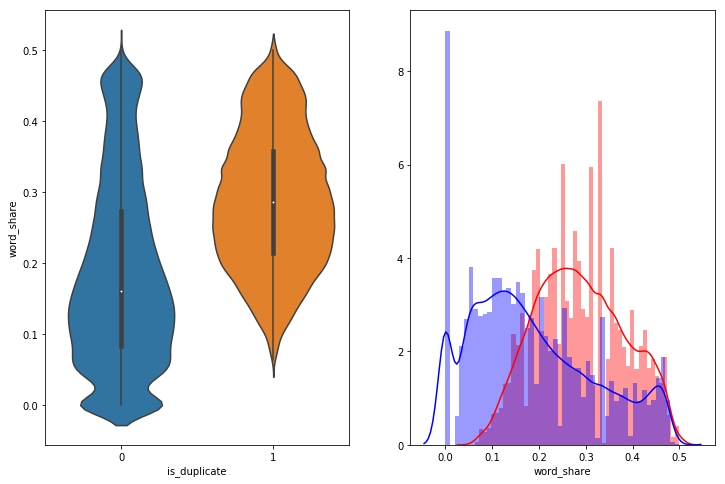

In [43]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

##### 3.3.1.2 Feature: word_Common

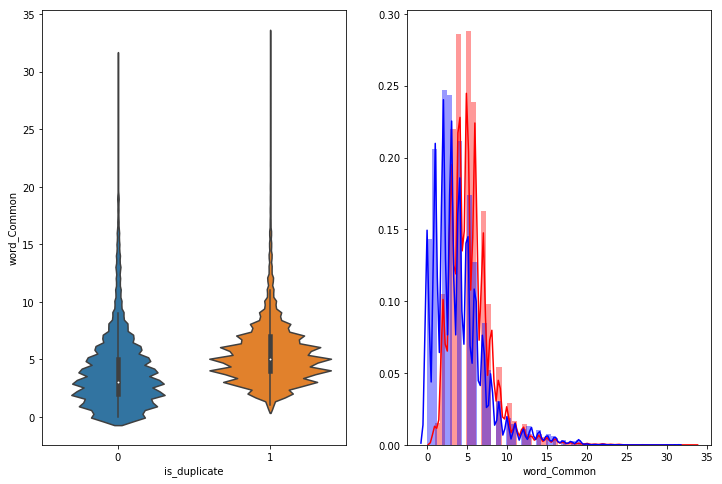

In [44]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

The distributions of the word_Common feature in similar and non-similar questions are highly overlapping

##### 3.3.1.2 Feature: n_words

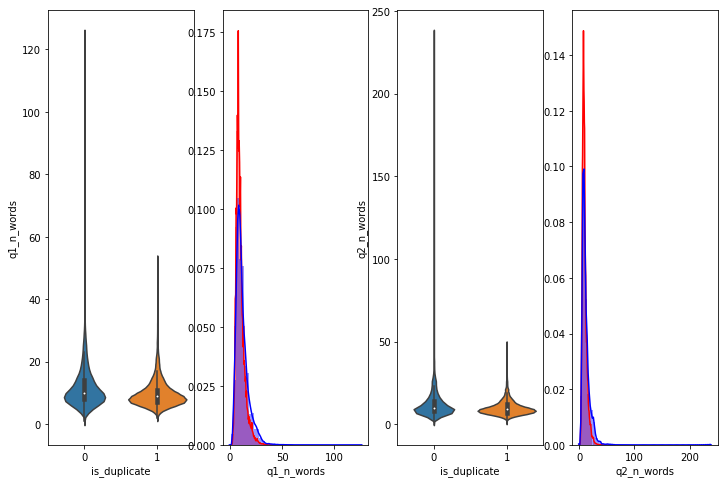

In [45]:
plt.figure(figsize=(12, 8))

plt.subplot(1,4,1)
sns.violinplot(x = 'is_duplicate', y = 'q1_n_words', data = df[0:])

plt.subplot(1,4,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['q1_n_words'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['q1_n_words'][0:] , label = "0" , color = 'blue' )

plt.subplot(1,4,3)
sns.violinplot(x = 'is_duplicate', y = 'q2_n_words', data = df[0:])

plt.subplot(1,4,4)
sns.distplot(df[df['is_duplicate'] == 1.0]['q2_n_words'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['q2_n_words'][0:] , label = "0" , color = 'blue' )

plt.show()

The distributions of the n_words feature for question1 and question2 in similar and non-similar questions are highly overlapping

In [46]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [47]:
df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,32322,59515,59516,How many search queries does Quora serve daily?,How many search queries does Facebook serve da...,0,1,1,47,50,8,8,7.0,16.0,0.437500,2,0
1,23371,27772,43777,What are good gifts for a foreign visitor to b...,What are good gifts for a foreign visitor to b...,0,3,1,117,119,22,22,19.0,40.0,0.475000,4,2
2,232729,342804,342805,How do people get pregnant accidentally?,How do some people attain accidental enlighten...,0,1,1,40,51,6,7,3.0,13.0,0.230769,2,0
3,31217,8800,20190,What as your reaction when your heard about th...,What do you think about ban on Rs. 500 and Rs....,1,1,12,92,67,17,14,5.0,29.0,0.172414,13,11
4,61357,107142,33017,Which is the best online grocery shopping webs...,Which is the best online grocery shopping webs...,0,2,2,63,59,10,10,9.0,20.0,0.450000,4,0


## 3.4 Preprocessing of Text
- Preprocessing:
  - Removing html tags
  - Removing Punctuations
  - Performing stemming
  - Removing Stopwords
  - Expanding contractions etc.

In [49]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

## 3.5 Advanced Feature Extraction (NLP and Fuzzy Features)

Definition:

**Token** : You get a token by splitting sentence a space
**Stop_Word** : stop words as per NLTK.
**Word** : A token that is not a stop_word
Features:

- **cwc_min** : Ratio of common_word_count to min lenghth of word count of Q1 and Q2 
- cwc_min = common_word_count / (min(len(q1_words), len(q2_words)) 

- **cwc_max** : Ratio of common_word_count to max lenghth of word count of Q1 and Q2 
- cwc_max = common_word_count / (max(len(q1_words), len(q2_words)) 

- **csc_min** : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 
- csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops)) 

- **csc_max** : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
- csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops)) 

- **ctc_min** : Ratio of common_token_count to min lenghth of token count of Q1 and Q2
- ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens)) 


- **ctc_max** : Ratio of common_token_count to max lenghth of token count of Q1 and Q2
- ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens)) 


- **last_word_eq** : Check if First word of both questions is equal or not
- last_word_eq = int(q1_tokens[-1] == q2_tokens[-1]) 


- **first_word_eq** : Check if First word of both questions is equal or not
- first_word_eq = int(q1_tokens[0] == q2_tokens[0]) 


- **abs_len_diff** : Abs. length difference
- abs_len_diff = abs(len(q1_tokens) - len(q2_tokens)) 


- **mean_len** : Average Token Length of both Questions
- mean_len = (len(q1_tokens) + len(q2_tokens))/2 


- **fuzz_ratio** : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 

- **fuzz_partial_ratio** : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 

- **token_sort_ratio** : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 

- **token_set_ratio** : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 


- **longest_substr_ratio** : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
- longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [50]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [51]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    #df = pd.read_csv("../input/train.csv")
    df_nlp = extract_features(df)
    df_nlp.to_csv("nlp_features_train.csv", index=False)
df_nlp.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,32322,59515,59516,how many search queries does quora serve daily,how many search queries does facebook serve da...,0,1,1,47,50,8,8,7.0,16.0,0.4375,2,0,0.833319,0.833319,0.99995,0.99995,0.874989,0.874989,1.0,1.0,0.0,8.0,93,84,88,85,0.604167
1,23371,27772,43777,what are good gifts for a foreign visitor to b...,what are good gifts for a foreign visitor to b...,0,3,1,117,119,22,22,19.0,40.0,0.4750,4,2,0.909083,0.909083,0.99999,0.99999,0.833330,0.833330,1.0,1.0,0.0,24.0,98,98,98,98,0.801653


### 3.5.1 Analysis of extracted features
#### 3.5.1.1 Plotting Word clouds
- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [52]:
df_duplicate = df_nlp[df_nlp['is_duplicate'] == 1]
dfp_nonduplicate = df_nlp[df_nlp['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 73458
Number of data points in class 0 (non duplicate pairs) : 126542


In [53]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 3957375
Total number of words in non duplicate pair questions : 8262805


**Word Clouds generated from duplicate pair question's text**

Word Cloud for Duplicate Question pairs


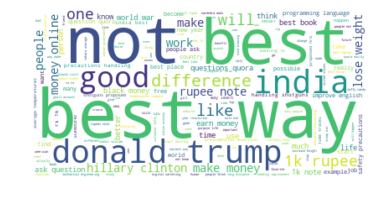

In [54]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

**Word Clouds generated from non duplicate pair question's text**

Word Cloud for non-Duplicate Question pairs:


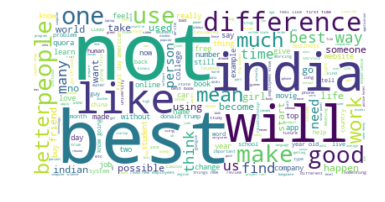

In [55]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

**3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']**

In [56]:
df_nlp.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,32322,59515,59516,how many search queries does quora serve daily,how many search queries does facebook serve da...,0,1,1,47,50,8,8,7.0,16.0,0.4375,2,0,0.833319,0.833319,0.99995,0.99995,0.874989,0.874989,1.0,1.0,0.0,8.0,93,84,88,85,0.604167
1,23371,27772,43777,what are good gifts for a foreign visitor to b...,what are good gifts for a foreign visitor to b...,0,3,1,117,119,22,22,19.0,40.0,0.4750,4,2,0.909083,0.909083,0.99999,0.99999,0.833330,0.833330,1.0,1.0,0.0,24.0,98,98,98,98,0.801653


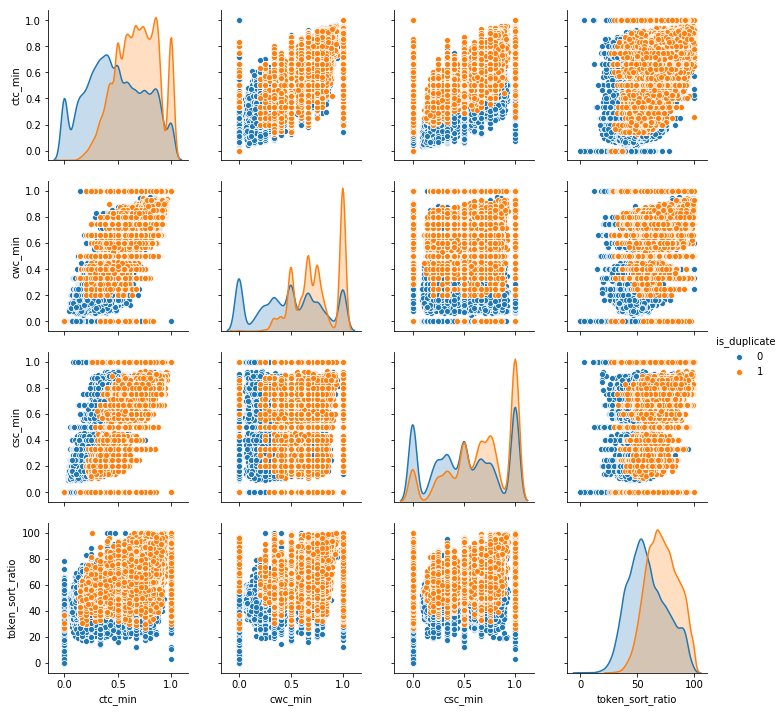

In [57]:
n = df_nlp.shape[0]
sns.pairplot(df_nlp[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

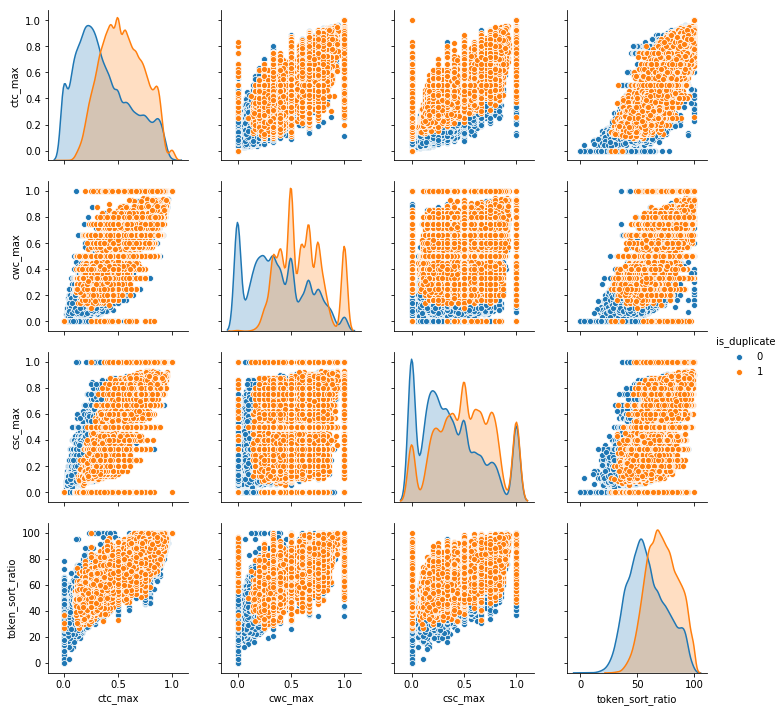

In [58]:
n = df_nlp.shape[0]
sns.pairplot(df_nlp[['ctc_max', 'cwc_max', 'csc_max', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_max', 'cwc_max', 'csc_max', 'token_sort_ratio'])
plt.show()

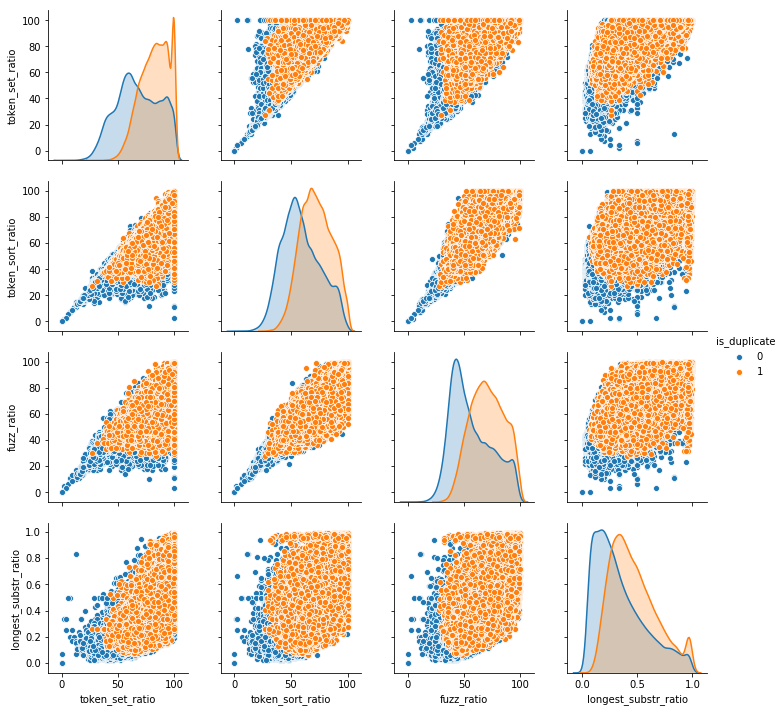

In [59]:
n = df_nlp.shape[0]
sns.pairplot(df_nlp[['token_set_ratio', 'token_sort_ratio', 'fuzz_ratio', 'longest_substr_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['token_set_ratio', 'token_sort_ratio', 'fuzz_ratio', 'longest_substr_ratio'])
plt.show()

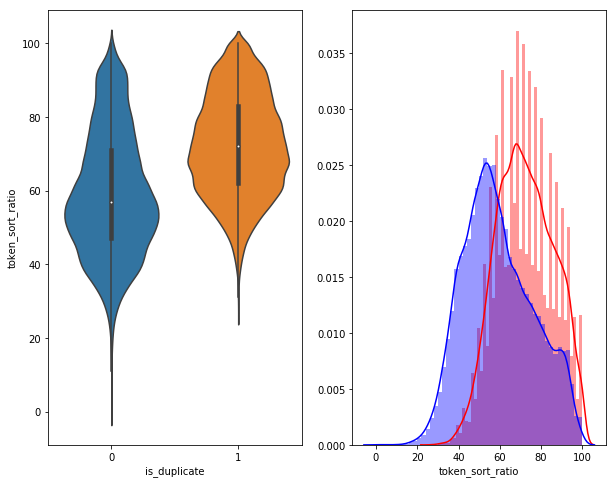

In [60]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df_nlp[0:] , )

plt.subplot(1,2,2)
sns.distplot(df_nlp[df_nlp['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df_nlp[df_nlp['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

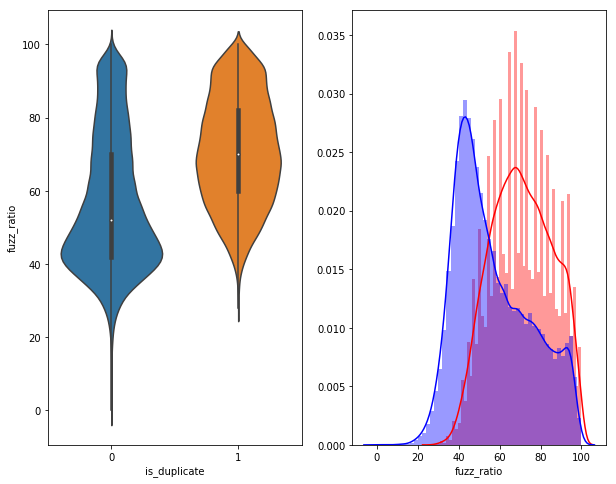

In [61]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df_nlp[0:] , )

plt.subplot(1,2,2)
sns.distplot(df_nlp[df_nlp['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df_nlp[df_nlp['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

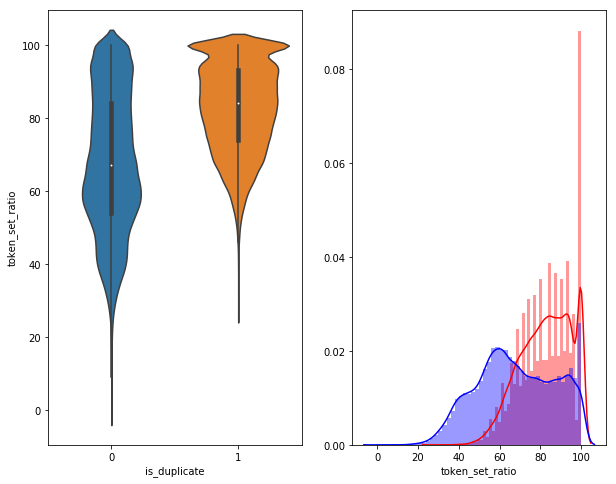

In [62]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_set_ratio', data = df_nlp[0:] , )

plt.subplot(1,2,2)
sns.distplot(df_nlp[df_nlp['is_duplicate'] == 1.0]['token_set_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df_nlp[df_nlp['is_duplicate'] == 0.0]['token_set_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

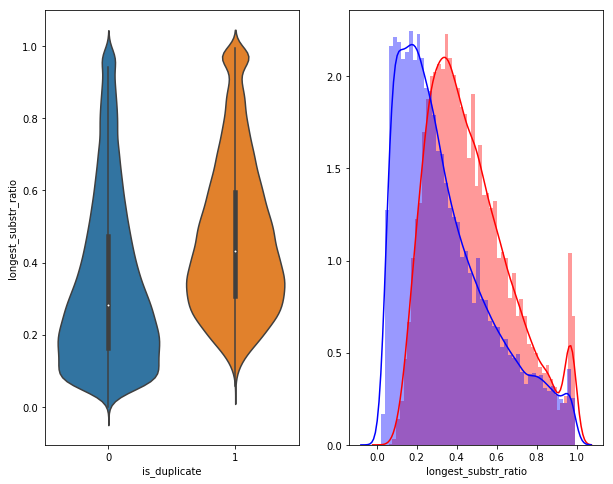

In [63]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'longest_substr_ratio', data = df_nlp[0:] , )

plt.subplot(1,2,2)
sns.distplot(df_nlp[df_nlp['is_duplicate'] == 1.0]['longest_substr_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df_nlp[df_nlp['is_duplicate'] == 0.0]['longest_substr_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

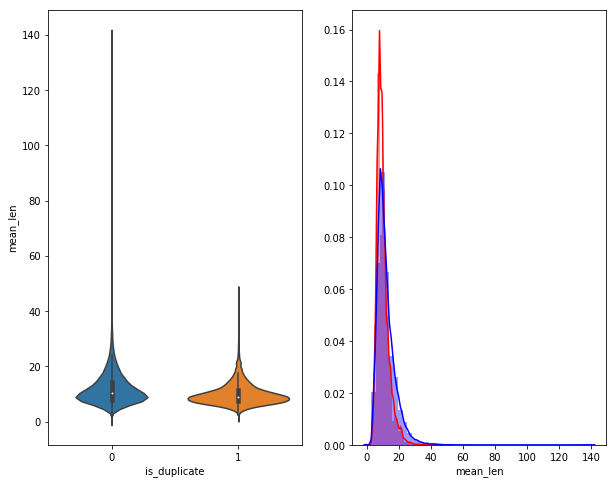

In [64]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'mean_len', data = df_nlp[0:] , )

plt.subplot(1,2,2)
sns.distplot(df_nlp[df_nlp['is_duplicate'] == 1.0]['mean_len'][0:] , label = "1", color = 'red')
sns.distplot(df_nlp[df_nlp['is_duplicate'] == 0.0]['mean_len'][0:] , label = "0" , color = 'blue' )
plt.show()

### 3.5.2 Visualization

In [65]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df_nlp[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [66]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.010s...
[t-SNE] Computed neighbors for 5000 samples in 0.353s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.121600
[t-SNE] Computed conditional probabilities in 0.328s
[t-SNE] Iteration 50: error = 82.9763412, gradient norm = 0.0451880 (50 iterations in 3.816s)
[t-SNE] Iteration 100: error = 70.4430084, gradient norm = 0.0102115 (50 iterations in 2.096s)
[t-SNE] Iteration 150: error = 68.4931717, gradient norm = 0.0055246 (50 iterations in 1.897s)
[t-SNE] Iteration 200: error = 67.6605377, gradient norm = 0.0038391 (50 iterations in 1.876s)
[t-SNE] Iteration 250: error = 67.1729813, gradient norm = 0.0036477

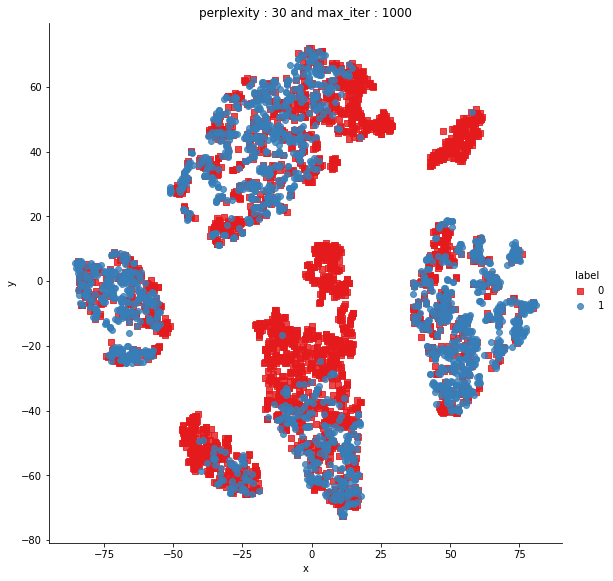

In [67]:
df_tsne = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df_tsne, x='x', y='y', hue='label', fit_reg=False, height=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [ ]:
!ls

In [ ]:
df_nlp.head()

In [68]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,32322,59515,59516,how many search queries does quora serve daily,how many search queries does facebook serve da...,0,1,1,47,50,8,8,7.0,16.0,0.4375,2,0,0.833319,0.833319,0.99995,0.99995,0.874989,0.874989,1.0,1.0,0.0,8.0,93,84,88,85,0.604167
1,23371,27772,43777,what are good gifts for a foreign visitor to b...,what are good gifts for a foreign visitor to b...,0,3,1,117,119,22,22,19.0,40.0,0.4750,4,2,0.909083,0.909083,0.99999,0.99999,0.833330,0.833330,1.0,1.0,0.0,24.0,98,98,98,98,0.801653


## 3.6 Featurizing text data with tfidf weighted word-vectors

In [69]:
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [70]:
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [71]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,32322,59515,59516,how many search queries does quora serve daily,how many search queries does facebook serve da...,0,1,1,47,50,8,8,7.0,16.0,0.437500,2,0,0.833319,0.833319,0.999950,0.999950,0.874989,0.874989,1.0,1.0,0.0,8.0,93,84,88,85,0.604167
1,23371,27772,43777,what are good gifts for a foreign visitor to b...,what are good gifts for a foreign visitor to b...,0,3,1,117,119,22,22,19.0,40.0,0.475000,4,2,0.909083,0.909083,0.999990,0.999990,0.833330,0.833330,1.0,1.0,0.0,24.0,98,98,98,98,0.801653
2,232729,342804,342805,how do people get pregnant accidentally,how do some people attain accidental enlighten...,0,1,1,40,51,6,7,3.0,13.0,0.230769,2,0,0.249994,0.249994,0.999950,0.666644,0.499992,0.428565,0.0,1.0,1.0,6.5,72,67,65,72,0.268293
3,31217,8800,20190,what as your reaction when your heard about th...,what do you think about ban on rs 500 and rs ...,1,1,12,92,67,17,14,5.0,29.0,0.172414,13,11,0.571420,0.499994,0.499992,0.374995,0.499996,0.411762,0.0,1.0,3.0,15.5,76,70,51,55,0.242424
4,61357,107142,33017,which is the best online grocery shopping webs...,which is the best online grocery shopping webs...,0,2,2,63,59,10,10,9.0,20.0,0.450000,4,0,0.833319,0.833319,0.999975,0.999975,0.899991,0.899991,0.0,1.0,0.0,10.0,95,87,92,93,0.883333


In [72]:
question1 = list(df['question1'])

In [73]:
question2 = list(df['question2'])

In [74]:
questions = question1+question2

In [75]:
print((questions[:2],questions[100000:100002]))

(['how many search queries does quora serve daily ', 'what are good gifts for a foreign visitor to bring when they are invited to someone own home in iraq for the first time '], ['how many search queries does facebook serve daily ', 'what are good gifts for a foreign visitor to bring when they are invited to someone own home in israel for the first time '])


In [ ]:
#questions = df["question1"] + df["question2"]

In [76]:
tfidf_vect = TfidfVectorizer(lowercase=False)
tfidf_vect.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf_vect.get_feature_names(), tfidf_vect.idf_))

In [ ]:
!pip install spacy

In [ ]:
!python -m spacy download en

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy". https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics.

In [77]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
import tqdm
import spacy
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in (list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 384])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


In [78]:
#import datetime
#start = datetime.now()
vecs2 = []
for qu2 in (list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 384])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)
#print("The time taken to run this cell:",(datetime.now-start))

In [79]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,q1_feats_m,q2_feats_m
0,32322,59515,59516,how many search queries does quora serve daily,how many search queries does facebook serve da...,0,1,1,47,50,8,8,7.0,16.0,0.4375,2,0,0.833319,0.833319,0.99995,0.99995,0.874989,0.874989,1.0,1.0,0.0,8.0,93,84,88,85,0.604167,"[10.088073521852493, 67.02059051394463, 72.740...","[23.84084916114807, 56.75823128223419, 77.0799..."
1,23371,27772,43777,what are good gifts for a foreign visitor to b...,what are good gifts for a foreign visitor to b...,0,3,1,117,119,22,22,19.0,40.0,0.4750,4,2,0.909083,0.909083,0.99999,0.99999,0.833330,0.833330,1.0,1.0,0.0,24.0,98,98,98,98,0.801653,"[27.648869782686234, 44.80248239636421, 65.400...","[13.702041536569595, 30.377590715885162, 52.63..."


In [81]:
df_q1 = pd.DataFrame(df.q1_feats_m.values.tolist(), index= df.index)
df_q2 = pd.DataFrame(df.q2_feats_m.values.tolist(), index= df.index)

In [82]:
df_q1.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383
0,10.088074,67.020591,72.740703,-40.891798,-37.651500,87.045107,-125.371287,21.355922,108.789089,-27.220260,-2.489648,-27.532753,42.563602,-37.875948,1.089198,-31.893305,-88.968064,-17.869885,-47.319007,38.795429,34.485270,44.090742,-42.191534,-11.797279,-30.485661,-26.084663,0.033921,85.911528,-49.072416,40.934754,-21.638708,12.840155,18.273410,23.917388,-62.532777,-37.485595,40.595359,-33.553700,-41.370664,-47.812707,...,-9.674339,-3.573486,-35.476522,-3.110332,29.754349,-3.221250,-10.986101,-1.263245,-13.848881,23.623329,12.681821,-5.148989,0.882052,-26.608843,-9.510346,-27.400383,-16.272077,15.814696,27.596305,12.978012,-3.854958,-13.627977,15.651438,-3.950219,33.659053,-12.473673,-10.601608,5.910547,-0.910582,-1.448366,8.714679,23.828200,7.252226,-6.380593,15.720172,-5.954170,-14.553319,-1.015601,-6.122597,1.211001
1,27.648870,44.802482,65.400306,206.443401,-56.413835,10.766710,-174.154263,-115.594993,66.131623,13.836387,-17.003287,-15.301711,83.049983,-72.906635,-15.323858,54.977592,-181.059318,-138.388640,-127.749573,-70.175702,36.006275,14.319994,8.002965,35.116663,-120.135617,-0.033861,-81.313406,104.518987,-45.351954,-44.110075,37.618574,103.667082,117.302163,-0.621569,-30.665883,11.849146,190.593212,-67.791489,-23.430073,15.986833,...,-19.375903,-15.269701,-25.581813,40.057855,50.864576,-5.717773,-16.047995,34.054557,-40.784513,8.360679,16.942442,-11.858973,-30.955797,-39.314332,-11.011405,-43.895431,-5.314043,39.621471,30.292494,30.846979,-45.811573,-9.716253,14.847876,-12.889218,33.402888,17.394492,-25.957425,18.452282,-3.336122,4.646059,25.870442,21.981774,4.829343,-9.926297,23.155044,24.229668,-20.433902,6.066845,-3.959074,3.046174


In [83]:
df_q2.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383
0,23.840849,56.758231,77.079971,-20.299370,-18.749313,75.610645,-107.018889,21.513996,107.393677,-4.651701,20.199972,-26.483242,48.325971,-31.180366,-6.228694,-31.722569,-106.855398,-23.247949,-4.609337,30.373288,37.199311,31.135848,-42.231352,-5.112094,-28.080956,-44.512176,-14.062617,77.401183,-34.314968,24.812194,-34.482422,21.406863,11.636204,33.106412,-59.274369,-47.262156,41.643375,-18.414534,-51.136908,-63.277600,...,-12.432682,0.325698,-38.158525,5.622777,38.646640,-8.599632,-5.414317,0.330578,-18.084411,26.289315,10.678089,-4.480853,-0.952588,-23.578103,-17.548111,-21.591395,-16.167348,17.524040,31.139762,18.779414,-3.268349,-11.287537,20.367922,-2.822833,35.583847,-15.802414,-13.080763,1.539755,-0.683337,-7.676577,7.162646,28.863647,11.218491,-7.481099,19.705341,-6.393457,-20.713623,-2.925293,-4.443665,-1.929134
1,13.702042,30.377591,52.637329,234.099407,-47.725769,11.834744,-168.400678,-86.792174,77.443904,8.939640,-21.926599,-2.802841,69.007815,-84.545809,-11.153247,34.920336,-163.415805,-134.344098,-134.653698,-57.625008,33.740433,9.155574,1.794966,46.694318,-104.684178,18.898400,-80.836502,104.186630,-42.228184,-50.320758,32.682848,110.121407,105.617032,-11.898473,-17.055750,-1.910377,174.028808,-51.814497,7.224153,25.532641,...,-16.330294,-13.381348,-29.007694,39.291658,52.978822,-5.681099,-13.554928,35.569608,-37.006713,5.341547,16.137139,-15.167411,-29.529389,-35.704293,-8.307783,-44.568221,-10.577759,41.979064,31.344510,28.280762,-43.900566,-7.973263,12.907347,-11.421573,33.008183,15.443348,-26.347425,20.574379,-9.334663,1.627948,28.068548,20.972246,4.708498,-11.423794,27.092712,22.978525,-17.109376,8.833778,0.804523,5.868235


In [84]:
df_q1['id']=df['id']
df_q2['id']=df['id']
#df1  = df1.merge(df2, on='id',how='left')
df2  = df_q1.merge(df_q2, on='id',how='left')
result  = df.merge(df2, on='id',how='left')

In [85]:
result.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,q1_feats_m,q2_feats_m,0_x,1_x,2_x,3_x,4_x,5_x,...,344_y,345_y,346_y,347_y,348_y,349_y,350_y,351_y,352_y,353_y,354_y,355_y,356_y,357_y,358_y,359_y,360_y,361_y,362_y,363_y,364_y,365_y,366_y,367_y,368_y,369_y,370_y,371_y,372_y,373_y,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,32322,59515,59516,how many search queries does quora serve daily,how many search queries does facebook serve da...,0,1,1,47,50,8,8,7.0,16.0,0.4375,2,0,0.833319,0.833319,0.99995,0.99995,0.874989,0.874989,1.0,1.0,0.0,8.0,93,84,88,85,0.604167,"[10.088073521852493, 67.02059051394463, 72.740...","[23.84084916114807, 56.75823128223419, 77.0799...",10.088074,67.020591,72.740703,-40.891798,-37.651500,87.045107,...,-12.432682,0.325698,-38.158525,5.622777,38.646640,-8.599632,-5.414317,0.330578,-18.084411,26.289315,10.678089,-4.480853,-0.952588,-23.578103,-17.548111,-21.591395,-16.167348,17.524040,31.139762,18.779414,-3.268349,-11.287537,20.367922,-2.822833,35.583847,-15.802414,-13.080763,1.539755,-0.683337,-7.676577,7.162646,28.863647,11.218491,-7.481099,19.705341,-6.393457,-20.713623,-2.925293,-4.443665,-1.929134
1,23371,27772,43777,what are good gifts for a foreign visitor to b...,what are good gifts for a foreign visitor to b...,0,3,1,117,119,22,22,19.0,40.0,0.4750,4,2,0.909083,0.909083,0.99999,0.99999,0.833330,0.833330,1.0,1.0,0.0,24.0,98,98,98,98,0.801653,"[27.648869782686234, 44.80248239636421, 65.400...","[13.702041536569595, 30.377590715885162, 52.63...",27.648870,44.802482,65.400306,206.443401,-56.413835,10.766710,...,-16.330294,-13.381348,-29.007694,39.291658,52.978822,-5.681099,-13.554928,35.569608,-37.006713,5.341547,16.137139,-15.167411,-29.529389,-35.704293,-8.307783,-44.568221,-10.577759,41.979064,31.344510,28.280762,-43.900566,-7.973263,12.907347,-11.421573,33.008183,15.443348,-26.347425,20.574379,-9.334663,1.627948,28.068548,20.972246,4.708498,-11.423794,27.092712,22.978525,-17.109376,8.833778,0.804523,5.868235


In [86]:
print(result[result.isnull().any(axis=1)].head())

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, q1_feats_m, q2_feats_m, 0_x, 1_x, 2_x, 3_x, 4_x, 5_x, 6_x, 7_x, 8_x, 9_x, 10_x, 11_x, 12_x, 13_x, 14_x, 15_x, 16_x, 17_x, 18_x, 19_x, 20_x, 21_x, 22_x, 23_x, 24_x, 25_x, 26_x, 27_x, 28_x, 29_x, 30_x, 31_x, 32_x, 33_x, 34_x, 35_x, 36_x, 37_x, 38_x, 39_x, 40_x, 41_x, 42_x, 43_x, 44_x, 45_x, 46_x, 47_x, 48_x, 49_x, 50_x, 51_x, 52_x, 53_x, 54_x, 55_x, 56_x, 57_x, 58_x, 59_x, 60_x, 61_x, 62_x, 63_x, 64_x, 65_x, ...]
Index: []

[0 rows x 802 columns]


In [87]:
y_true = result["is_duplicate"]

In [88]:
result["questions"] = result["question1"] + result["question2"]

In [89]:
X_train,X_test, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.3)# splitting the data into 70:30

In [90]:
vect = TfidfVectorizer()
train = vect.fit_transform(X_train["questions"].values)
test = vect.transform(X_test["questions"])

In [91]:
#X_train.drop(X_train.index[0], inplace=True)
#X_test.drop(X_test.index[0], inplace=True)
#y_true = data['is_duplicate']
X_train.drop(['id','is_duplicate','question1','question2','qid1','qid2','questions'], axis=1, inplace=True)
X_test.drop(['id','is_duplicate','question1','question2','qid1','qid2','questions'], axis=1, inplace=True)

In [92]:
X_train.head(2)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,q1_feats_m,q2_feats_m,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,...,344_y,345_y,346_y,347_y,348_y,349_y,350_y,351_y,352_y,353_y,354_y,355_y,356_y,357_y,358_y,359_y,360_y,361_y,362_y,363_y,364_y,365_y,366_y,367_y,368_y,369_y,370_y,371_y,372_y,373_y,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
97808,1,1,33,120,6,26,3.0,30.0,0.100000,2,0,0.333322,0.076922,0.666644,0.181817,0.499992,0.115384,0.0,0.0,20.0,16.0,58,35,30,48,0.235294,"[22.32176160812378, 23.782968070358038, 1.5330...","[180.8286990225315, 127.51041913032532, 50.616...",22.321762,23.782968,1.533018,80.423534,-5.319613,28.883477,-98.131412,-42.766533,38.403044,-12.014353,22.038340,-40.888203,...,-22.323709,-7.859325,-25.337624,34.057288,73.573306,17.761260,12.275666,8.830938,-39.603056,16.021860,16.195362,-21.480859,-8.116039,-33.080805,-14.694221,-48.188531,-12.192698,27.964470,12.090832,29.492835,-46.056835,18.851040,6.407688,-33.357097,33.236261,29.623755,-42.471562,21.551006,-11.945443,-9.971590,28.216300,29.669415,-10.564998,-9.373923,37.327619,7.968688,-19.680737,0.178055,3.012405,0.704166
34386,2,1,65,145,15,27,4.0,35.0,0.114286,3,1,0.333328,0.199998,0.285710,0.181817,0.266665,0.142857,0.0,0.0,13.0,21.5,53,48,40,51,0.196970,"[35.35072576999664, 24.920985132455826, 55.525...","[60.13718781992793, 22.625044465065002, 95.939...",35.350726,24.920985,55.525116,124.027636,49.254446,24.989560,-80.868073,-44.562668,38.315917,49.635519,32.809818,-34.336195,...,-26.166729,14.469405,-39.576204,15.164607,81.400216,-18.095332,-7.588044,48.264271,-33.300491,3.140701,9.757310,-15.513129,-16.722358,-60.333035,-17.529833,-84.304177,-30.416202,56.171635,34.696968,26.516026,-59.775853,-11.990788,21.376406,-23.442769,63.580129,39.579366,-0.943585,43.841729,-34.818599,-9.365257,37.335724,56.373076,13.598720,-17.218150,32.824696,10.640543,-33.611722,1.484279,2.602145,8.272648


In [93]:
X_train.drop(['q1_feats_m', 'q2_feats_m'], axis=1, inplace=True)
X_test.drop(['q1_feats_m', 'q2_feats_m'], axis=1, inplace=True)

In [94]:
print(list(X_train.columns))

['freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio', '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x', '12_x', '13_x', '14_x', '15_x', '16_x', '17_x', '18_x', '19_x', '20_x', '21_x', '22_x', '23_x', '24_x', '25_x', '26_x', '27_x', '28_x', '29_x', '30_x', '31_x', '32_x', '33_x', '34_x', '35_x', '36_x', '37_x', '38_x', '39_x', '40_x', '41_x', '42_x', '43_x', '44_x', '45_x', '46_x', '47_x', '48_x', '49_x', '50_x', '51_x', '52_x', '53_x', '54_x', '55_x', '56_x', '57_x', '58_x', '59_x', '60_x', '61_x', '62_x', '63_x', '64_x', '65_x', '66_x', '67_x', '68_x', '69_x', '70_x', '71_x', '72_x', '73_x', '74_x', '75_x', '76_x', '77_x', '78_x', '79_x', 

In [ ]:
nan_row = X_train[X_train.isnull().any(1)]
print (nan_row)

In [95]:
print(X_train[X_train.isnull().any(axis=1)].head())
print(X_test[X_test.isnull().any(axis=1)].head())

Empty DataFrame
Columns: [freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, 0_x, 1_x, 2_x, 3_x, 4_x, 5_x, 6_x, 7_x, 8_x, 9_x, 10_x, 11_x, 12_x, 13_x, 14_x, 15_x, 16_x, 17_x, 18_x, 19_x, 20_x, 21_x, 22_x, 23_x, 24_x, 25_x, 26_x, 27_x, 28_x, 29_x, 30_x, 31_x, 32_x, 33_x, 34_x, 35_x, 36_x, 37_x, 38_x, 39_x, 40_x, 41_x, 42_x, 43_x, 44_x, 45_x, 46_x, 47_x, 48_x, 49_x, 50_x, 51_x, 52_x, 53_x, 54_x, 55_x, 56_x, 57_x, 58_x, 59_x, 60_x, 61_x, 62_x, 63_x, 64_x, 65_x, 66_x, 67_x, 68_x, 69_x, 70_x, 71_x, 72_x, 73_x, ...]
Index: []

[0 rows x 794 columns]
Empty DataFrame
Columns: [freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2, cwc_min, cwc_max, csc_min, csc_max, c

In [ ]:
X_train = X_train.fillna(X_train.mean())
#X_test = X_test.fillna(X_test.mean())

In [ ]:
print(X_train[X_train.isnull().any(axis=1)].head())
print(X_test[X_test.isnull().any(axis=1)].head())

In [ ]:
cols = list(X_train.columns)
for i in cols:
    X_train[i] = X_train[i].apply(pd.to_numeric)
    print(i)

In [ ]:
cols = list(X_test.columns)
for i in cols:
    X_test[i] = X_test[i].apply(pd.to_numeric)
    print(i)

# 4. Machine Learning Models

In [96]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## 4.1 Building a random model (Finding worst-case log-loss)

Log loss on Test Data using Random Model 0.8847547928332885


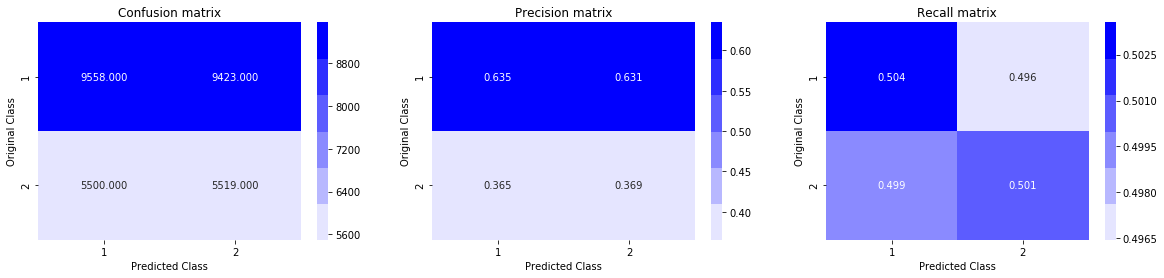

In [97]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
train_len = len(y_train)
test_len = len(y_test)
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

## 4.2 LogisticRegression with tfidf_w2v 

For values of alpha =  1e-10 The log loss is: 0.6575030424356176
For values of alpha =  1e-09 The log loss is: 0.6575030424356176
For values of alpha =  1e-08 The log loss is: 0.6575030424356176
For values of alpha =  1e-07 The log loss is: 0.6575030424356176
For values of alpha =  1e-06 The log loss is: 0.6575030424356176
For values of alpha =  1e-05 The log loss is: 0.5467696581298362
For values of alpha =  0.0001 The log loss is: 0.5414930782691609
For values of alpha =  0.001 The log loss is: 0.5475591738474286
For values of alpha =  0.01 The log loss is: 0.5426608357852492
For values of alpha =  0.1 The log loss is: 0.5470199052648061
For values of alpha =  1 The log loss is: 0.5368507829927686
For values of alpha =  10 The log loss is: 0.5306326614064393


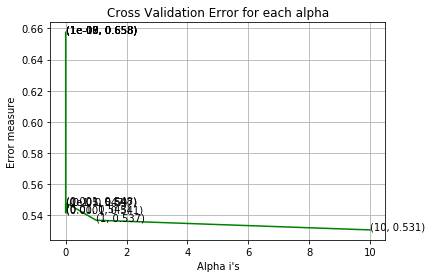

For values of best alpha =  10 The train log loss is: 0.5269958977422067
For values of best alpha =  10 The test log loss is: 0.5306326614064393
Total number of data points : 30000


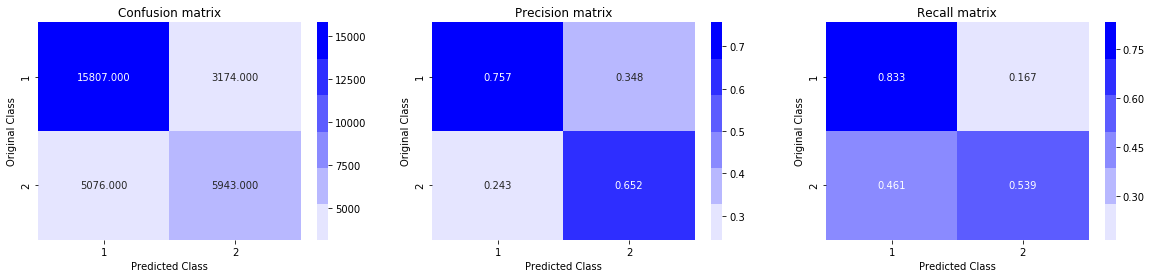

In [98]:
alpha = [10 ** x for x in range(-10, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## 4.3 LinearSVM with tfidf_w2v

For values of alpha =  1e-10 The log loss is: 0.6575030424356176
For values of alpha =  1e-09 The log loss is: 0.6575030424356176
For values of alpha =  1e-08 The log loss is: 0.6575030424356176
For values of alpha =  1e-07 The log loss is: 0.6575030424356176
For values of alpha =  1e-06 The log loss is: 0.6575030424356176
For values of alpha =  1e-05 The log loss is: 0.5506574165656367
For values of alpha =  0.0001 The log loss is: 0.5484679316766414
For values of alpha =  0.001 The log loss is: 0.5438147829174965
For values of alpha =  0.01 The log loss is: 0.5500528717316421
For values of alpha =  0.1 The log loss is: 0.545995697529267
For values of alpha =  1 The log loss is: 0.537317382867404
For values of alpha =  10 The log loss is: 0.5317223096084054


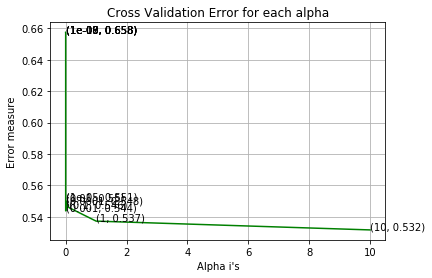

For values of best alpha =  10 The train log loss is: 0.5269958977422067
For values of best alpha =  10 The test log loss is: 0.5306326614064393
Total number of data points : 30000


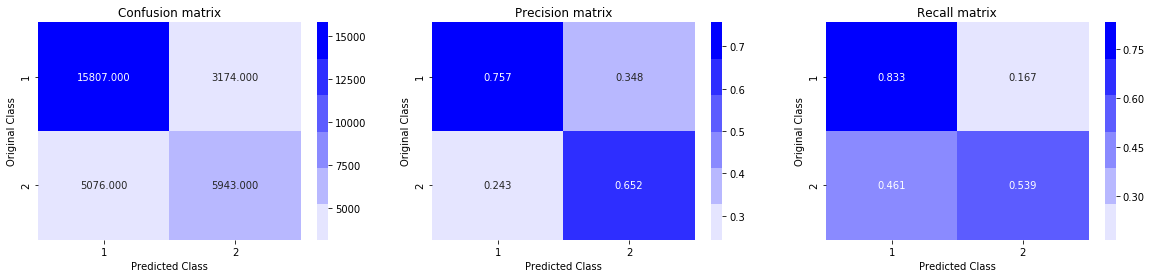

In [99]:
alpha = [10 ** x for x in range(-10, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## 4.4 LogisticRegression with tfidf

For values of alpha =  1e-10 The log loss is: 0.5645408030428718
For values of alpha =  1e-09 The log loss is: 0.5648944748430067
For values of alpha =  1e-08 The log loss is: 0.5634689512386667
For values of alpha =  1e-07 The log loss is: 0.5631273507345038
For values of alpha =  1e-06 The log loss is: 0.5441983177792534
For values of alpha =  1e-05 The log loss is: 0.5195977331569003
For values of alpha =  0.0001 The log loss is: 0.5372291595897316
For values of alpha =  0.001 The log loss is: 0.5674620947530512
For values of alpha =  0.01 The log loss is: 0.5807849178755291
For values of alpha =  0.1 The log loss is: 0.625993830448838
For values of alpha =  1 The log loss is: 0.6357343794720292
For values of alpha =  10 The log loss is: 0.6366557798744484


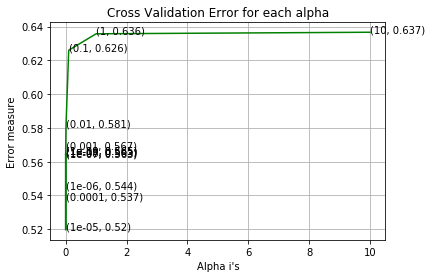

For values of best alpha =  1e-05 The train log loss is: 0.4558651515744864
For values of best alpha =  1e-05 The test log loss is: 0.5195977331569003
Total number of data points : 30000


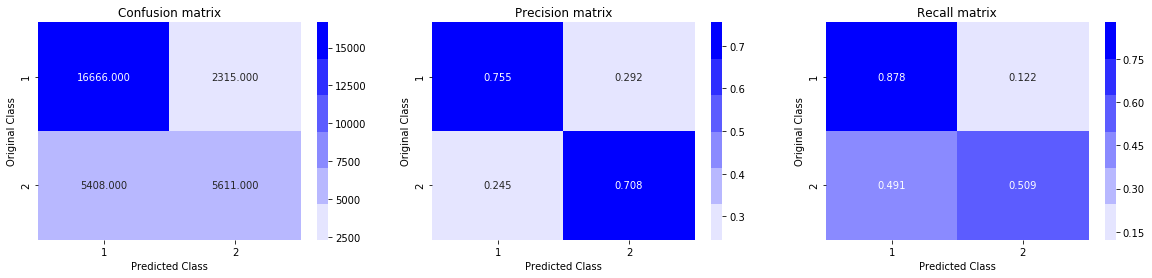

In [100]:
alpha = [10 ** x for x in range(-10, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train, y_train)
    predict_y = sig_clf.predict_proba(test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train, y_train)

predict_y = sig_clf.predict_proba(train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## 4.5 LinearSVM with tfidf

For values of alpha =  1e-10 The log loss is: 0.5659257035611679
For values of alpha =  1e-09 The log loss is: 0.5623083130215499
For values of alpha =  1e-08 The log loss is: 0.5629184770869097
For values of alpha =  1e-07 The log loss is: 0.5631401361615055
For values of alpha =  1e-06 The log loss is: 0.5516997174928132
For values of alpha =  1e-05 The log loss is: 0.5267118830546038
For values of alpha =  0.0001 The log loss is: 0.5379383774900414
For values of alpha =  0.001 The log loss is: 0.5775919397042423
For values of alpha =  0.01 The log loss is: 0.5786247277386127
For values of alpha =  0.1 The log loss is: 0.6367088945286129
For values of alpha =  1 The log loss is: 0.6367088944686392
For values of alpha =  10 The log loss is: 0.6367088945132091


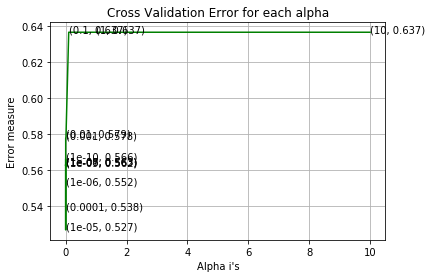

For values of best alpha =  1e-05 The train log loss is: 0.4558651515744864
For values of best alpha =  1e-05 The test log loss is: 0.5195977331569003
Total number of data points : 30000


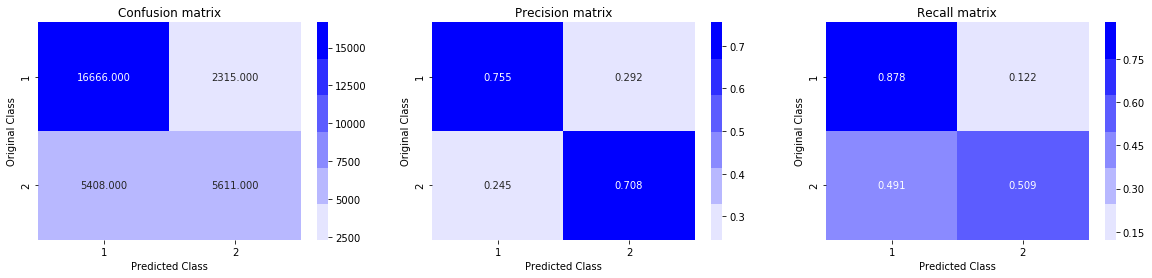

In [101]:
alpha = [10 ** x for x in range(-10, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train, y_train)
    predict_y = sig_clf.predict_proba(test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train, y_train)

predict_y = sig_clf.predict_proba(train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## 4.6 XGBoost Classifier with tfidf_w2v  

In [102]:

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss
import xgboost as xgb
from datetime import datetime

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


clf = xgb.XGBClassifier()
param = { 'n_estimators':[5, 10, 15, 20, 30, 50,100], 
         'max_depth' :[5, 10, 25, 50, 100, 500, 1000],
        'learning_rate' :[10**-5,10**-4,10**-3,10**-2,10**-1,10**0,10]} #params we need to try on classifier
model = RandomizedSearchCV(clf,param,cv=3,scoring='neg_log_loss',n_jobs=-1)
start_time =  timer(None)
model.fit(X_train,y_train)
timer(start_time)


 Time taken: 0 hours 31 minutes and 24.16 seconds.


In [103]:
print(model.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
       max_depth=500, min_child_weight=1, missing=None, n_estimators=5,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


For values of best learning rate = 0.1  The train log loss is: 0.10708805125387652
For values of best learning rate = 0.1 The test log loss is: 0.4945780916273594
Total number of data points : 30000


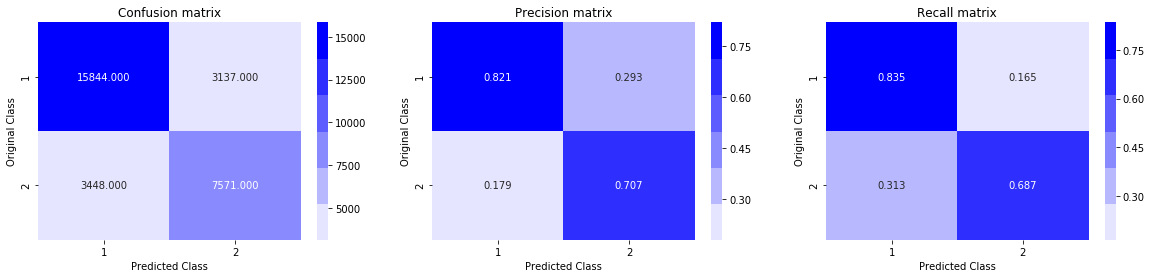

In [105]:
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
       max_depth=500, min_child_weight=1, missing=None, n_estimators=5,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

clf.fit(X_train, y_train)

predict_y = clf.predict_proba(X_train)
print('For values of best learning rate = 0.1 ',"The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=0.1))
predict_y = clf.predict_proba(X_test)
print('For values of best learning rate = 0.1', "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=0.1))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# SUMMARY:

**Summary of step-by-step process:**
1. Take the input from the Train.csv file and stored the data in the data frame named df.
2. I have taken sample data of size 100k from df, due to computing constraints.
3. Perfomed some data analysis on the raw data it seened that the data is imbalanced.
4. identifying and removing dulicates.
5. Basic feature extraction and its analyis.
6. Data cleaning is performed.
7. Advanced feature extraction is performed like    (cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio)
8. feature analysis on Advanced features.
9. Data visualization on advanced features using tsne.
10. vectorization is performed using GLOVE on text data and mearged 'df' dataframe.
11. Split the data with the ratio 70:30.
12. tfidf vectorization is preformed on test and train data.
13. finally, experiment with machine learning models the log-loss as a metric. 

# CONCLUSION

- In the above table we can see the for LogisticRegression and linearSVM tfidf featurization will work good compared to tfidf_w2v.
- using XgboostClassifier with tfidf_w2v featurization can reduse the log loss but the computational complexity of running Xgboost is very high.
